In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import time 
from scipy import stats
from scipy.stats import skew 
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Data Ingestion
raw_data = pd.read_csv('data/RFM.csv')

# EDA

In [18]:
dataset = raw_data.copy()

In [19]:
dataset

,Recency,Frequency,Monetary
0,39,2,4550
1,3,4,4256
2,78,1,2000
3,3,2,2695
4,2,2,7913
...,...,...,...
388902,85,1,1149
388903,27,3,3290
388904,29,8,4328
388905,10,20,11729



### Raw Data Distribution

In [20]:
dataset.describe()

,Recency,Frequency,Monetary
count,388907.000000,388907.000000,388907.000000
mean,30.996868,7.128954,3864.139308
std,23.493806,7.263205,2968.631476
min,0.000000,1.000000,100.000000
25%,10.000000,3.000000,1700.000000
50%,29.000000,5.000000,3110.000000
75%,46.000000,9.000000,5357.000000
max,86.000000,100.000000,111017.000000


In [21]:
def print_hist(data,special=""):
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    col = ['Recency','Frequency','Monetary']
    color = ['tab:blue','red','orange']
    for i in range(3):
        name = special+str(col[i])
        axs[i].hist(data[name],bins=50,color=color[i])
        axs[i].set_title(name)
    fig.tight_layout()

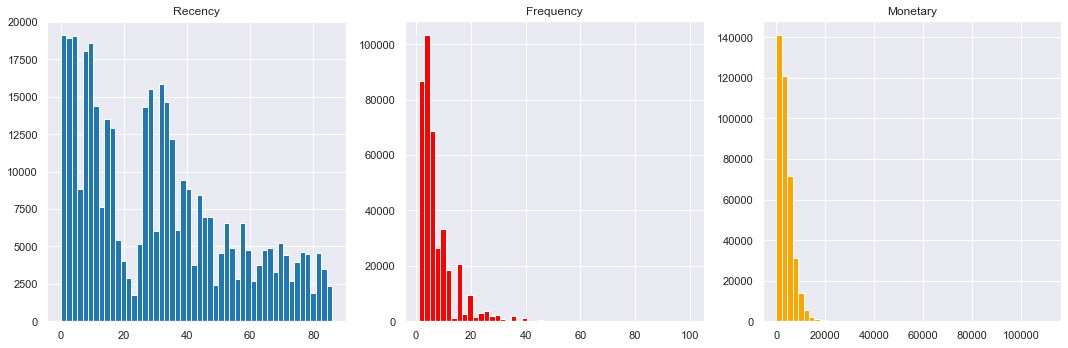

In [22]:
print_hist(dataset,"")

In [23]:
def print_boxplot(data,special=""):
    fig, axs = plt.subplots(3,1,figsize=(12,5))
    col = ['Recency','Frequency','Monetary']
    color = ['tab:blue','red','orange']
    for i in range(3):
        sns.boxplot(x=col[i],data=data,ax=axs[i],color=color[i])
    fig.tight_layout()

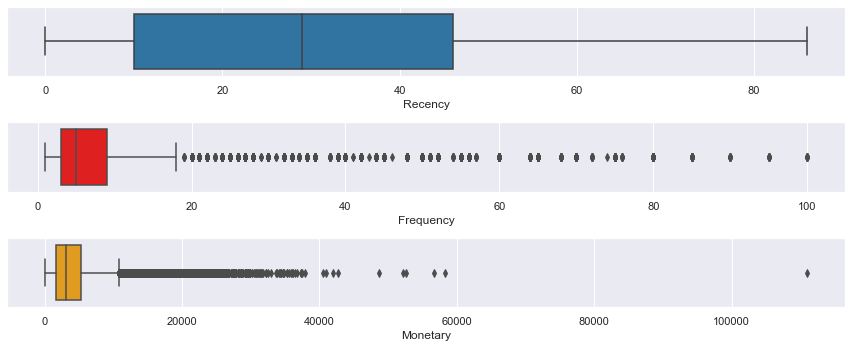

In [24]:
print_boxplot(dataset,"")

### Drop Outliers

In [25]:
def detect_outlier(data):
    outliers = []
    threshold= 3
    mean = np.mean(data)
    std =np.std(data)
    return min([y for y in data if np.abs( (y-mean) / std ) > threshold], default=1e18)

In [26]:
outlier_limits = {c:detect_outlier(dataset[c]) for c in dataset.columns}
print('Outliers Lower Limit')
outlier_limits

Outliers Lower Limit


{'Frequency': 29, 'Monetary': 12771, 'Recency': 1e+18}

In [27]:
dataset_outlier = dataset[(dataset['Recency']>=outlier_limits['Recency'])
                        |(dataset['Frequency']>=outlier_limits['Frequency'])
                        |(dataset['Monetary']>=outlier_limits['Monetary'])]

In [28]:
#Drop Outliers
dataset.drop(dataset_outlier.index,inplace=True)
dataset.reset_index(inplace=True,drop=True)

### Data distribution after dropping outliers

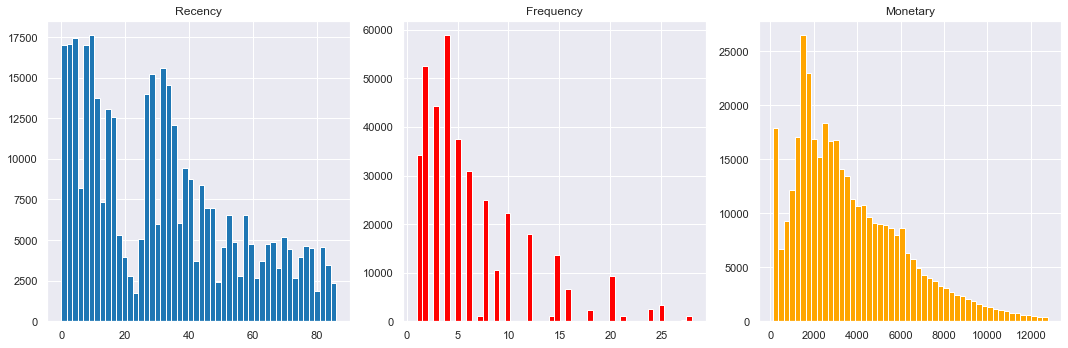

In [29]:
print_hist(dataset,"")

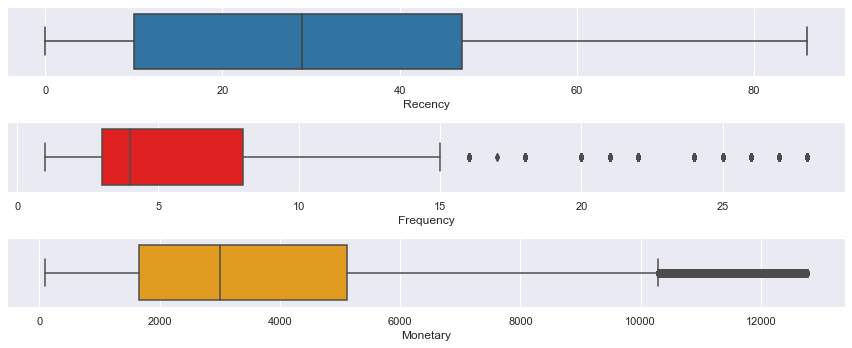

In [30]:
print_boxplot(dataset,"")

In [31]:
#dataset['Monetary'] = (dataset['Monetary'] / (5*1e5)).apply(np.ceil) * 5*1e5

### Correlation between variables

<AxesSubplot:>

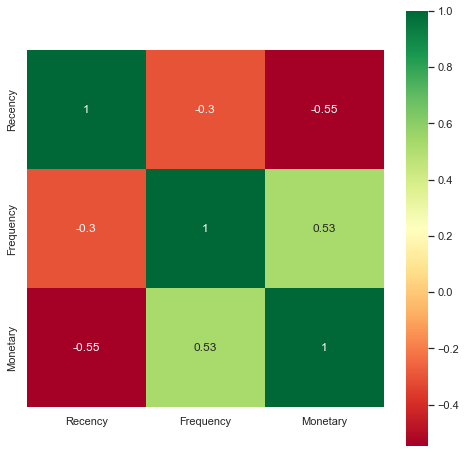

In [32]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(8,8),facecolor='white')
sns.heatmap(correlation_matrix,square=True,annot=True,cmap="RdYlGn")

### Normalizing data

In [33]:
def normalize_data(data, columns):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(d, columns=columns)
    for c in columns :
        data['Norm'+c] = scaled_df[c]

### Elbow Method

In [34]:
def elbow_method(data, columns):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    data_em = data[columns]
    K = range(1, 10)
 
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(data_em)
        kmeanModel.fit(data_em)
     
        distortions.append(sum(np.min(cdist(data_em, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / data_em.shape[0])
        inertias.append(kmeanModel.inertia_)
 
        mapping1[k] = sum(np.min(cdist(data_em, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / data_em.shape[0]
        mapping2[k] = kmeanModel.inertia_
        
    for key, val in mapping1.items():
        print(f'{key} : {val}')
        
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    for key, val in mapping2.items():
        print(f'{key} : {val}')
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

# KMeans

In [35]:
def kmeans_(data,n,col):
    #initiliaze model
    kmeans = KMeans(n_clusters=n,random_state=123,max_iter=800,n_init=30,algorithm='full')
    #fitting
    data['Cluster'] = kmeans.fit_predict(data[col])

In [36]:
def plot_2d(data,col):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(data[col[i]],data[col[j]],c=data['Cluster'],cmap='viridis',s=5)
            axs[i, j].set_xlabel(col[i])
            axs[i, j].set_ylabel(col[j])
    fig.tight_layout()  

In [37]:
def plot_3d(data,col):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d') 
    # plot points
    ax.scatter(data[col[0]],
                data[col[1]],
                data[col[2]], 
                c=data["Cluster"],
                cmap='viridis',
                s=5,
                alpha=1)
    ax.view_init()
    plt.xlabel(col[0])
    plt.ylabel(col[1])
    ax.set_zlabel(col[2])
    plt.show()

In [38]:
data_rfm = dataset.copy()

In [39]:
normalize_data(data_rfm,['Recency','Frequency','Monetary'])

In [ ]:
elbow_method(data_rfm,['NormRecency','NormFrequency','NormMonetary'])

In [ ]:
kmeans_(data_rfm,4,['NormRecency','NormFrequency','NormMonetary'])

In [ ]:
rst = data_rfm.groupby('Cluster').agg({'Recency':['min','max','mean'],
                                'Frequency':['min','max','mean'],
                                'Monetary':['min','max','mean'],
                                'NormRecency':['min','max'],
                                'NormFrequency':['min','max'],
                                'NormMonetary':['min','max','size']})
rst

In [ ]:
data_sample = data_rfm.sample(int(data_rfm.shape[0]*0.1))

In [ ]:
plot_2d(data_sample,['Recency','Frequency','Monetary'])

In [ ]:
plot_3d(data_sample,['Recency','Frequency','Monetary'])